In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


## Note:
So for This notebook, our goal is to Experiment the Classification of GTZAN Audio file dataset, with using Deep leanring Architectures.

- In this notebook we have used Convolutional neural nets, Recurrent neural nets, and at last a combination of both a hybrid model.


#### Importing Libraries


In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import librosa, IPython
# import soundfile as sf
import librosa.display as lplt
seed = 12
np.random.seed(seed)
from tqdm import tqdm
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Input, TimeDistributed,Reshape
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model

#### Preprocessing the Data

Loading the data from Kaggle and Tracking its path

In [140]:

data_path = path + "/Data"

In [37]:
data_dir = path + "/Data/genres_original"

In [38]:
data_dir

'/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

In [39]:
! ls {data_dir}

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


MFCC : Mel Frequency Cepstral Coefficient, very Important Audio features as they capture the timbre and textural characteristics of the audio

NMFCC -> Basically here we are gonna extract 40 MFCC features per audio frame.

FIXED_LENGTH -> fixinng all auio samples for having 1300 time stamps

In [40]:
N_MFCC = 40
FIXED_LENGTH = 1300

In [42]:
genres = os.listdir(data_dir)
genres

['disco',
 'metal',
 'reggae',
 'blues',
 'rock',
 'classical',
 'jazz',
 'hiphop',
 'country',
 'pop']

In [53]:
genre_path = os.path.join(data_dir, genres[0])
genre_path

'/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco'

In [54]:
file_path = os.listdir(genre_path)
# file_path

In [55]:
SAMPLE_RATE = 22050
DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

- Function to extract mfcc for cnn model we are going to use, capturing mfcc patterns over time

In [61]:
def extract_mfcc_cnn(signal, sample_rate, num_mfcc, n_fft, hop_length):
    mfcc = librosa.feature.mfcc(y = signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc.T[..., np.newaxis]  # shape: (time, mfcc, 1)

- funtion to extract mfcc in sequential order for Our LSTM model,
as LSTM are good with sequential data like time seires

In [62]:
def extract_mfcc_rnn(signal, sample_rate, num_mfcc, n_fft, hop_length):
    mfcc = librosa.feature.mfcc(y = signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc.T  # shape: (time, mfcc)

- Capturing mel-spectrogram, for our hyrbid models as it captures both spectral and temporal patterns

In [63]:
def extract_melspectrogram(signal, sample_rate, n_mels=128, n_fft=2048, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=n_fft,
                                               hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db.T[..., np.newaxis]  # Shape: (time, mel, 1)


preprocess data and store the extracted features

In [68]:
def process_dataset_in_memory(dataset_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "labels": [],
        "genres": [],
        "cnn": [],
        "rnn": [],
        "hybrid": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath != dataset_path:
            genre_label = os.path.split(dirpath)[-1]
            data["genres"].append(genre_label)
            print(f"\nProcessing: {genre_label}")

            for file in filenames:
                file_path = os.path.join(dirpath, file)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                except Exception as e:
                    print(f"Skipped file {file_path} due to error: {e}")
                    continue

                for d in range(num_segments):
                    start = samples_per_segment * d
                    end = start + samples_per_segment
                    segment = signal[start:end]

                    mfcc_cnn = extract_mfcc_cnn(segment, sr, num_mfcc, n_fft, hop_length)
                    mfcc_rnn = extract_mfcc_rnn(segment, sr, num_mfcc, n_fft, hop_length)
                    mfcc_hybrid = extract_melspectrogram(segment, sr, n_mels=128, n_fft=n_fft, hop_length=hop_length)

                    if (len(mfcc_rnn) == num_mfcc_vectors_per_segment):  # Same for all
                        data["cnn"].append(mfcc_cnn)
                        data["rnn"].append(mfcc_rnn)
                        data["hybrid"].append(mfcc_hybrid)
                        data["labels"].append(i - 1)

                        print(f"{file_path}, segment {d+1} ✅")

    return data

In [70]:
data = process_dataset_in_memory(data_dir)

Streaming output truncated to the last 5000 lines.
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00079.wav, segment 3 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00079.wav, segment 4 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00079.wav, segment 5 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00030.wav, segment 1 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00030.wav, segment 2 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00030.wav, segment 3 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00030.wav, segment 4 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00030.wav, segment 5 ✅
/kaggle/input/gtzan-dataset-music-genre-classification/Data/g

#### Model Architecture

##### CNN model Architecture

In [71]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##### Bidirectional RNN Architecture

In [73]:
def build_rnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

##### Hybrid Model Architecture
This Hybrid model Architecture combines CNN and LSTM:

CNN → extracts spatial features (e.g., patterns in pitch across frequency/time).

LSTM → captures temporal patterns in the extracted spatial features.

In [97]:
def build_hybrid_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)  # reshape for LSTM
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [75]:
X_cnn = np.array(data["cnn"])
X_rnn = np.array(data["rnn"])
X_hybrid = np.array(data["hybrid"])
y = np.array(data["labels"])

In [79]:
X_cnn.shape
print(X_cnn.shape)
print(X_rnn.shape)
print(X_hybrid.shape)
print(y.shape)

(4993, 259, 13, 1)
(4993, 259, 13)
(4993, 259, 128, 1)
(4993,)


#### CNN Model Traingin and Eval

In [82]:
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

In [83]:
print(X_cnn_train.shape)
print(X_cnn_test.shape)
print(y_cnn_train.shape)
print(y_cnn_test.shape)

(3994, 259, 13, 1)
(999, 259, 13, 1)
(3994,)
(999,)


In [111]:
cnn_model = build_cnn_model(X_cnn.shape[1:], num_classes=10)

In [112]:
history_cnn = cnn_model.fit(X_cnn_train, y_cnn_train, validation_data=(X_cnn_test, y_cnn_test),
                    epochs=30, batch_size=32)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.2313 - loss: 3.0155 - val_accuracy: 0.3073 - val_loss: 1.8546
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3428 - loss: 1.8044 - val_accuracy: 0.4294 - val_loss: 1.5813
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4134 - loss: 1.6382 - val_accuracy: 0.5095 - val_loss: 1.3818
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4602 - loss: 1.4746 - val_accuracy: 0.5566 - val_loss: 1.2632
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4940 - loss: 1.3681 - val_accuracy: 0.5646 - val_loss: 1.2638
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5224 - loss: 1.2969 - val_accuracy: 0.5826 - val_loss: 1.1923
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5456 - loss: 1.2186 - val_accuracy: 0.6026 - val_loss: 1.2220
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5761 - loss: 1.1651 - val_accuracy

#### RNN model Training and Eval

In [113]:
X_rnn_train, X_rnn_test, y_rnn_train, y_rnn_test = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

In [114]:
print(X_rnn_train.shape)
print(X_rnn_test.shape)
print(y_rnn_train.shape)
print(y_rnn_test.shape)

(3994, 259, 13)
(999, 259, 13)
(3994,)
(999,)


In [115]:
rnn_model = build_rnn_model(X_rnn.shape[1:], num_classes=10)

In [116]:
history_rnn = rnn_model.fit(X_rnn_train, y_rnn_train, validation_data=(X_rnn_test, y_rnn_test),
                    epochs=30, batch_size=32)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.2561 - loss: 2.0528 - val_accuracy: 0.4274 - val_loss: 1.5396
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4109 - loss: 1.5884 - val_accuracy: 0.5035 - val_loss: 1.3753
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5088 - loss: 1.3749 - val_accuracy: 0.5275 - val_loss: 1.3016
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5413 - loss: 1.2776 - val_accuracy: 0.5806 - val_loss: 1.1796
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5715 - loss: 1.1892 - val_accuracy: 0.5696 - val_loss: 1.1976
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6113 - loss: 1.0823 - val_accuracy: 0.6076 - val_loss: 1.1418
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6172 - loss: 1.0714 - val_accuracy: 0.5886 - val_loss: 1.1694
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6153 - loss: 1.0674 - val_a

#### Hybrid model(CNN+LSTM) Traingin and Eval

In [117]:
# train test split for Hybrid Model
X_hybrid_train, X_hybrid_test, y_hybrid_train, y_hybrid_test = train_test_split(X_hybrid, y, test_size=0.2, random_state=42)

In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [120]:
hybrid_model = build_hybrid_model(X_hybrid.shape[1:], num_classes=10)

In [121]:
history_hybrid = hybrid_model.fit(X_hybrid_train, y_hybrid_train, validation_data=(X_hybrid_test, y_hybrid_test),
                    epochs=30, batch_size=32, callbacks = [checkpoint])

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2683 - loss: 2.0398
Epoch 1: val_accuracy improved from -inf to 0.18619, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.2687 - loss: 2.0386 - val_accuracy: 0.1862 - val_loss: 2.2429
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4268 - loss: 1.5696
Epoch 2: val_accuracy improved from 0.18619 to 0.47848, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.4270 - loss: 1.5694 - val_accuracy: 0.4785 - val_loss: 1.4625
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5274 - loss: 1.3561
Epoch 3: val_accuracy did not improve from 0.47848
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.5275 - loss: 1.3557 - val_accuracy: 0.1542 - val_loss: 2.6693
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5934 - loss: 1.2037
Epoch 4: val_accuracy did not improve from 0.47848
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.5935 - loss: 1.2035 - val_accuracy: 0.4174 - val_loss: 1.6464
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6465 - loss: 1.0603
Epoch 5: val_accuracy did not improve from 0.47848
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6464 - loss: 1.0604 - val_accuracy: 0.3073 - val_loss: 2.1534
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6728 - loss: 0.9769
Epoch 6: val_accuracy d

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7312 - loss: 0.8209 - val_accuracy: 0.5686 - val_loss: 1.2687
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7394 - loss: 0.7848
Epoch 9: val_accuracy did not improve from 0.56857
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.7394 - loss: 0.7848 - val_accuracy: 0.5015 - val_loss: 1.5071
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7616 - loss: 0.7301
Epoch 10: val_accuracy did not improve from 0.56857
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7616 - loss: 0.7301 - val_accuracy: 0.5025 - val_loss: 1.3869
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7945 - loss: 0.6582
Epoch 11: val_accuracy improved from 0.56857 to 0.61662, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7945 - loss: 0.6582 - val_accuracy: 0.6166 - val_loss: 1.0292
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8198 - loss: 0.5795
Epoch 12: val_accuracy did not improve from 0.61662
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.8197 - loss: 0.5797 - val_accuracy: 0.5566 - val_loss: 1.2809
Epoch 13/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8273 - loss: 0.5482
Epoch 13: val_accuracy improved from 0.61662 to 0.62462, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8273 - loss: 0.5483 - val_accuracy: 0.6246 - val_loss: 1.0526
Epoch 14/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8498 - loss: 0.5169
Epoch 14: val_accuracy improved from 0.62462 to 0.74575, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.8497 - loss: 0.5170 - val_accuracy: 0.7457 - val_loss: 0.7095
Epoch 15/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8426 - loss: 0.5010
Epoch 15: val_accuracy improved from 0.74575 to 0.78779, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8426 - loss: 0.5010 - val_accuracy: 0.7878 - val_loss: 0.6327
Epoch 16/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8691 - loss: 0.4424
Epoch 16: val_accuracy did not improve from 0.78779
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8691 - loss: 0.4423 - val_accuracy: 0.7718 - val_loss: 0.6966
Epoch 17/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8510 - loss: 0.4302
Epoch 17: val_accuracy did not improve from 0.78779
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.8510 - loss: 0.4302 - val_accuracy: 0.7167 - val_loss: 0.7864
Epoch 18/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8715 - loss: 0.3940
Epoch 18: val_accuracy did not improve from 0.78779
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8716 - loss: 0.3939 - val_accuracy: 0.6316 - val_loss: 1.0943
Epoch 19/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8890 - loss: 0.3573
Epoch 19: val_ac

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8849 - loss: 0.3543 - val_accuracy: 0.7958 - val_loss: 0.6416
Epoch 21/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9099 - loss: 0.3087
Epoch 21: val_accuracy did not improve from 0.79580
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9099 - loss: 0.3087 - val_accuracy: 0.7087 - val_loss: 0.9120
Epoch 22/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9153 - loss: 0.2816
Epoch 22: val_accuracy did not improve from 0.79580
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9152 - loss: 0.2816 - val_accuracy: 0.7608 - val_loss: 0.6959
Epoch 23/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9216 - loss: 0.2757
Epoch 23: val_accuracy did not improve from 0.79580
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9215 - loss: 0.2757 - val_accuracy: 0.6787 - val_loss: 0.9472
Epoch 24/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9195 - loss: 0.2473
Epoch 24: val_ac

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9195 - loss: 0.2474 - val_accuracy: 0.8478 - val_loss: 0.4715
Epoch 25/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9235 - loss: 0.2401
Epoch 25: val_accuracy did not improve from 0.84785
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9235 - loss: 0.2401 - val_accuracy: 0.8258 - val_loss: 0.5631
Epoch 26/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9302 - loss: 0.2357
Epoch 26: val_accuracy did not improve from 0.84785
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9302 - loss: 0.2356 - val_accuracy: 0.7838 - val_loss: 0.6504
Epoch 27/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9453 - loss: 0.1913
Epoch 27: val_accuracy did not improve from 0.84785
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9453 - loss: 0.1915 - val_accuracy: 0.7117 - val_loss: 0.9032
Epoch 28/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9468 - loss: 0.1770
Epoch 28: val_ac

### Accuracy and Loss Visualization And Results

In [122]:
# Use a modern seaborn palette
sns.set(style="whitegrid")
colors = sns.color_palette("tab10")

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_model_comparison(history_cnn, history_rnn, history_hybrid):
    epochs = range(1, len(history_cnn.history['accuracy']) + 1)

    plt.figure(figsize=(16, 6))

    # === Accuracy Plot ===
    plt.subplot(1, 2, 1)

    models = [('CNN', history_cnn), ('RNN', history_rnn), ('Hybrid', history_hybrid)]
    markers = ['o', '^', 's']

    for i, (label, history) in enumerate(models):
        train_acc = smooth_curve(history.history['accuracy'])
        val_acc = smooth_curve(history.history['val_accuracy'])

        plt.plot(epochs, train_acc, label=f'{label} - Train', linestyle='-', marker=markers[i], color=colors[i])
        plt.plot(epochs, val_acc, label=f'{label} - Val', linestyle='--', marker=markers[i], color=colors[i])
        plt.fill_between(epochs, train_acc, val_acc, alpha=0.1, color=colors[i])

    plt.title('Smoothed Model Accuracy with Gap', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)

    # === Loss Plot ===
    plt.subplot(1, 2, 2)

    for i, (label, history) in enumerate(models):
        train_loss = smooth_curve(history.history['loss'])
        val_loss = smooth_curve(history.history['val_loss'])

        plt.plot(epochs, train_loss, label=f'{label} - Train', linestyle='-', marker=markers[i], color=colors[i])
        plt.plot(epochs, val_loss, label=f'{label} - Val', linestyle='--', marker=markers[i], color=colors[i])
        plt.fill_between(epochs, train_loss, val_loss, alpha=0.1, color=colors[i])

    plt.title('Smoothed Model Loss with Gap', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

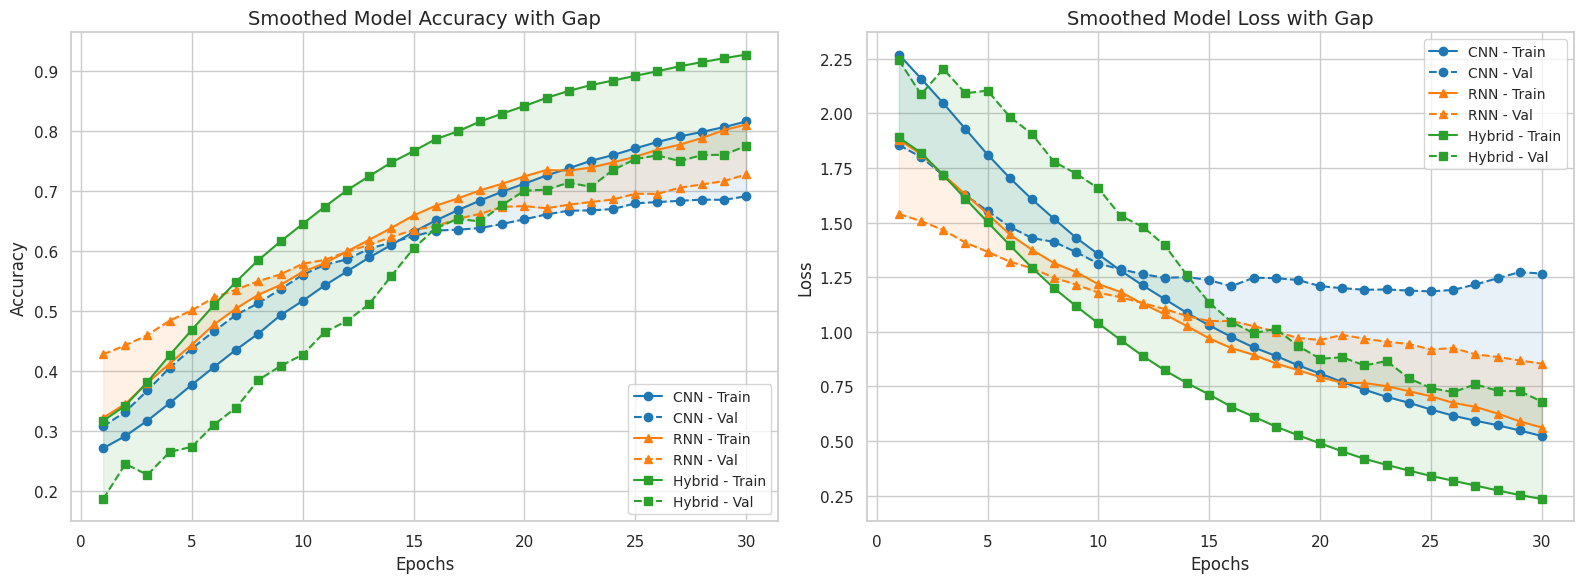

In [123]:
plot_model_comparison(history_cnn, history_rnn, history_hybrid)


#### Insights from the Training Curves  
1. Hybrid Model Performs Best Overall  
    **Accuracy**: The Hybrid model consistently outperforms both CNN and RNN in validation accuracy across all epochs.

    **Loss**: Hybrid model also shows lowest validation loss, suggesting better generalization.

2. CNN May Be Underfitting  
    **Train vs Val Accuracy (CNN):** There's a very small gap between training and validation accuracy, both flattening early, suggesting limited learning capacity.

    **Loss Plot:** Loss plateaus and doesn't drop significantly after 15 epochs.

    *Insight: The CNN architecture may be too shallow or not expressive enough for the dataset.*

3. RNN Generalizes Better Than CNN    
    Train Accuracy > Val Accuracy but not by much. Still, both steadily increase.

    Loss gap between Train/Val is narrower than CNN and less noisy than Hybrid.

    *Insight: The RNN learns temporal patterns better than CNN for this task, showing balanced performance.*

4. Hybrid Model Shows Slight Overfitting  
    Train Accuracy > Val Accuracy consistently (gap starts increasing after ~20 epochs).

    Loss Gap: There’s a visible divergence in loss curves toward the end (train loss keeps falling while val loss flattens).

    *Insight: The Hybrid model learns more complex patterns, but after 20 epochs, it starts overfitting, so early stopping would be ideal.*

*- Trying the best saved model and checking for its prediction*

In [125]:
from tensorflow.keras.models import load_model

# Load best-performing model (assumes checkpoint saved it)
best_model = load_model("best_model.h5")  # Use your checkpoint path here

# Evaluate it on test data
test_loss, test_acc = best_model.evaluate(X_hybrid_test, y_hybrid_test)
print(f"Test Accuracy: {test_acc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8517 - loss: 0.4427
Test Accuracy: 0.8478


- getting the prediction for Confusion matrix and Classification report

In [128]:
# Predict genre class probabilities
y_pred_probs = best_model.predict(X_hybrid_test)
y_pred_probs

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


array([[1.44660749e-04, 2.94089463e-04, 2.53628707e-03, ...,
        6.58347562e-04, 1.01946783e-03, 1.15554512e-03],
       [1.62628257e-05, 3.24041612e-04, 1.63878151e-03, ...,
        1.32414891e-04, 8.23788287e-04, 4.91650833e-04],
       [9.54705902e-05, 9.95250106e-01, 7.29937346e-06, ...,
        1.84193102e-03, 1.53187520e-05, 1.95692828e-05],
       ...,
       [9.94429648e-01, 1.16366195e-04, 1.18027430e-03, ...,
        6.54669187e-04, 3.66061402e-04, 6.50382790e-05],
       [1.55679630e-02, 2.51286267e-03, 6.09761511e-04, ...,
        2.61745910e-04, 7.88609743e-01, 3.56231555e-02],
       [2.14035084e-04, 2.59709370e-04, 1.02143688e-02, ...,
        7.36613758e-04, 3.33671160e-02, 2.21310509e-03]], dtype=float32)

In [131]:
# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred

array([6, 6, 1, 8, 1, 1, 7, 7, 8, 2, 4, 9, 8, 0, 0, 7, 8, 0, 5, 0, 1, 4,
       8, 2, 1, 1, 9, 0, 3, 5, 9, 0, 9, 8, 5, 3, 8, 4, 3, 4, 8, 7, 9, 8,
       2, 0, 5, 9, 0, 0, 8, 2, 3, 9, 2, 2, 8, 0, 5, 0, 4, 1, 4, 3, 1, 5,
       2, 9, 9, 1, 6, 0, 9, 0, 7, 0, 3, 2, 9, 0, 1, 4, 1, 3, 3, 8, 4, 3,
       6, 0, 8, 1, 9, 6, 0, 0, 1, 4, 9, 9, 3, 9, 2, 0, 7, 8, 1, 2, 6, 3,
       2, 6, 7, 8, 6, 2, 6, 5, 0, 0, 4, 6, 9, 2, 7, 5, 2, 2, 3, 9, 7, 6,
       8, 4, 4, 2, 5, 4, 3, 2, 5, 8, 3, 8, 3, 0, 0, 9, 8, 1, 0, 5, 3, 3,
       8, 0, 4, 0, 7, 4, 0, 2, 9, 5, 0, 1, 0, 8, 4, 4, 6, 8, 8, 8, 0, 3,
       1, 3, 3, 8, 9, 2, 0, 4, 3, 4, 3, 2, 2, 4, 7, 5, 4, 4, 6, 3, 2, 5,
       3, 1, 7, 9, 9, 3, 9, 3, 7, 0, 5, 1, 1, 3, 9, 1, 4, 6, 4, 5, 6, 6,
       8, 6, 4, 8, 8, 6, 8, 1, 9, 1, 1, 3, 4, 2, 6, 4, 4, 2, 3, 3, 3, 8,
       1, 2, 8, 4, 5, 1, 3, 0, 5, 9, 6, 2, 2, 5, 1, 1, 2, 1, 7, 6, 8, 0,
       0, 3, 0, 0, 1, 8, 2, 8, 8, 9, 8, 1, 3, 4, 9, 5, 8, 9, 3, 1, 1, 8,
       1, 7, 5, 6, 2, 4, 0, 4, 0, 6, 8, 1, 2, 5, 9,

In [132]:
# Convert one-hot encoded true labels to class indices
y_true = y_hybrid_test

In [134]:
class_labels = ['blues', 'classical', 'country', 'disco', 'hiphop',
                'jazz', 'metal', 'pop', 'reggae', 'rock']

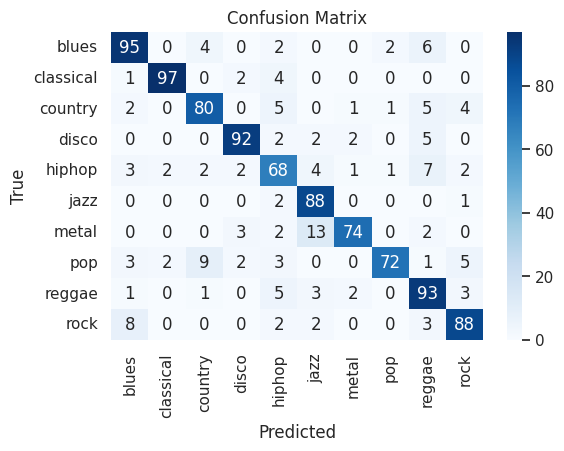

In [137]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_labels)


In [138]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print("📊 Classification Report:\n")
print(report)


📊 Classification Report:

              precision    recall  f1-score   support

       blues       0.84      0.87      0.86       109
   classical       0.96      0.93      0.95       104
     country       0.83      0.82      0.82        98
       disco       0.91      0.89      0.90       103
      hiphop       0.72      0.74      0.73        92
        jazz       0.79      0.97      0.87        91
       metal       0.93      0.79      0.85        94
         pop       0.95      0.74      0.83        97
      reggae       0.76      0.86      0.81       108
        rock       0.85      0.85      0.85       103

    accuracy                           0.85       999
   macro avg       0.85      0.85      0.85       999
weighted avg       0.85      0.85      0.85       999



Classification Report Insights
1. Overall Accuracy:
    The model achieves an overall accuracy of 85% on the test set, which is a strong performance considering the task involves distinguishing between 10 different music genres.

2. Class-wise Performance:

    - Best Performing Classes:

        Classical shows the highest performance with a precision of 96%, recall of 93%, and F1-score of 95%, indicating the model is highly confident and accurate when predicting this genre.

        Disco and Metal also performed well, each with high precision and reasonably balanced recall and F1-scores.

    - Moderate to Lower Performance Classes:

        Hiphop had the lowest precision (72%) and a relatively lower F1-score (73%), suggesting the model finds it harder to distinguish hiphop from other genres.

        Pop had high precision (95%) but lower recall (74%), indicating many pop samples were misclassified as other genres.

3. Balanced Performance:  
    The macro and weighted averages of precision, recall, and F1-score are all 0.85, which shows that the model performs consistently across most classes without being heavily biased toward any particular genre.

4. Recall and Precision Trade-offs:

    Some genres like Jazz have a very high recall (97%) but lower precision (79%), meaning the model identifies most jazz tracks correctly but sometimes incorrectly predicts other genres as jazz.

    Conversely, Pop shows the opposite — high precision but lower recall — indicating the model is very cautious and precise when it does predict pop, but misses some actual pop tracks.

5. Support Distribution:   
    Each genre class has around 90–110 test samples, which makes the evaluation fair and representative across classes.

